In [2]:
# pip install tensorflow
# pip install keras
# pip install numpy
# pip install matplotlib
# pip install pandas
# pip install scikit-learn
# pip install opencv-contrib-python

ResNet50

In [3]:
# Libraries
import os
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

Check Image Corruption

In [4]:
from PIL import UnidentifiedImageError

def check_images(directory):
    corrupted_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # This will raise an exception if the image is corrupted
            except (UnidentifiedImageError, IOError) as e:
                corrupted_images.append(file_path)
                print(f"Corrupted image: {file_path} - {e}")
    return corrupted_images

corrupted_images = check_images('images')
print(f"Total corrupted images: {len(corrupted_images)}")


Total corrupted images: 0


In [5]:
# def preprocess_image(image_path, size=(224, 224)):
#     try:
#         img = Image.open(image_path)
        
#         # Quality enhancement
#         enhancer = ImageEnhance.Sharpness(img)
#         img = enhancer.enhance(2.0)  # Increase sharpness
        
#         # Noise reduction
#         image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
#         image = cv2.GaussianBlur(image, (5, 5), 0)
#         img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
#         # Consistency
#         img = img.resize(size, Image.LANCZOS)

#         # Normalization
#         img_array = np.array(img) / 255.0
    
#         # Convert back to image
#         img = Image.fromarray((img_array * 255).astype(np.uint8))
        
#         return img
#     except (UnidentifiedImageError, IOError) as e:
#         print(f"Error processing image {image_path}: {e}")
#         return None

# input_dir = 'images_train_test_val/train'
# output_dir = 'processed_images'

# # Apply preprocessing and save to new directory
# for category in os.listdir(input_dir):
#     category_path = os.path.join(input_dir, category)
#     if os.path.isdir(category_path):
#         output_category_path = os.path.join(output_dir, category)
#         if not os.path.exists(output_category_path):
#             os.makedirs(output_category_path)
#         for image_name in os.listdir(category_path):
#             image_path = os.path.join(category_path, image_name)
#             preprocessed_img = preprocess_image(image_path)
#             if preprocessed_img:
#                 preprocessed_img.save(os.path.join(output_category_path, image_name))


In [6]:
train_dir = 'data/processed_images'
val_dir = 'data/images_train_test_val/validation'
test_dir = 'data/images_train_test_val/test'

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 7350 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.


In [7]:
def create_model():
    base_model = ResNet50(weights='imagenet', include_top=False)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)

    predictions = Dense(21, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model = Model(inputs=base_model.input, outputs=base_model.output)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

model = create_model()


In [8]:
import json
import os

class SaveHistoryCallback(tf.keras.callbacks.Callback):
    def __init__(self, file_path):
        super(SaveHistoryCallback, self).__init__()
        self.file_path = file_path
        # Create the file initially or clear existing file
        if not os.path.exists(file_path):
            with open(file_path, 'w') as f:
                json.dump({}, f)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        with open(self.file_path, 'r+') as f:
            history = json.load(f)
            for key, value in logs.items():
                if key in history:
                    history[key].append(value)
                else:
                    history[key] = [value]
            f.seek(0)  # Go to the beginning of the file
            json.dump(history, f, indent=4)

In [9]:
# Define callbacks
checkpoint = ModelCheckpoint(
    'models/best_ResNet_model.keras', 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    mode='min',
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[checkpoint, early_stopping, SaveHistoryCallback('models/resNet_history.json')],
)


Epoch 1/20


c:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6826 - loss: 9.1833
Epoch 1: val_loss improved from inf to 11.32406, saving model to models/best_ResNet_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 1125s 9s/step - accuracy: 0.6841 - loss: 9.1759 - val_accuracy: 0.0505 - val_loss: 11.3241
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9803 - loss: 7.0753
Epoch 2: val_loss improved from 11.32406 to 9.65029, saving model to models/best_ResNet_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 1070s 9s/step - accuracy: 0.9804 - loss: 7.0726 - val_accuracy: 0.0543 - val_loss: 9.6503
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9908 - loss: 5.7992
Epoch 3: val_loss improved from 9.65029 to 9.00357, saving model to models/best_ResNet_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 1068s 9s/step - accuracy: 0.9908 - loss: 5.7966 - val_accuracy: 0.0514 - val_loss: 9.0036
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9928 - loss: 4.5973
Epoch 4: val_loss 

In [10]:
# Evaluate the model
model = tf.keras.models.load_model('models/best_ResNet_model.keras')
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(val_generator)
test_loss, test_acc = model.evaluate(test_generator)

print(f'Train accuracy: {train_acc:.4f}, Validation accuracy: {val_acc:.4f}, Test accuracy: {test_acc:.4f}')

115/115 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.9815 - loss: 0.1941
33/33 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.9537 - loss: 0.2799
17/17 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9493 - loss: 0.2689
Train accuracy: 0.9816, Validation accuracy: 0.9619, Test accuracy: 0.9552


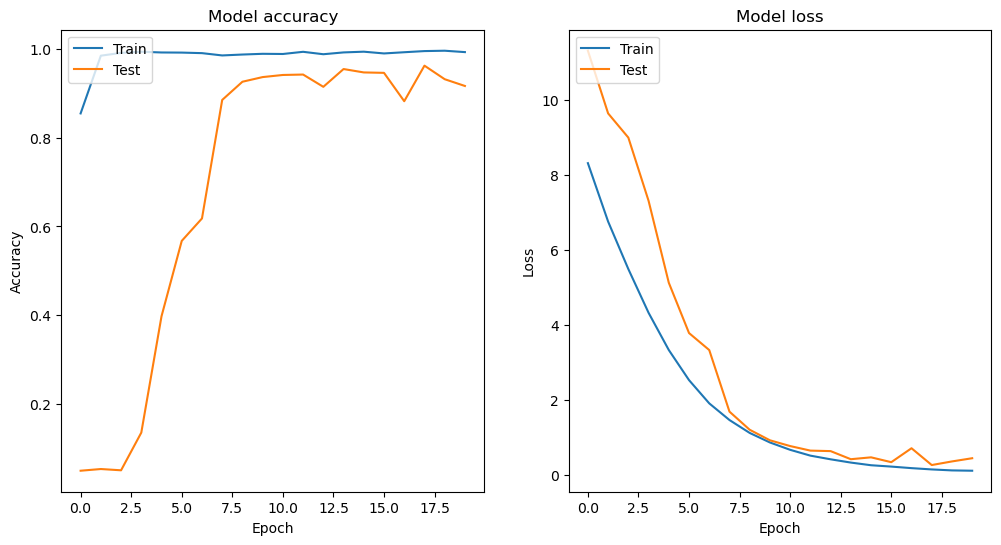

In [11]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step


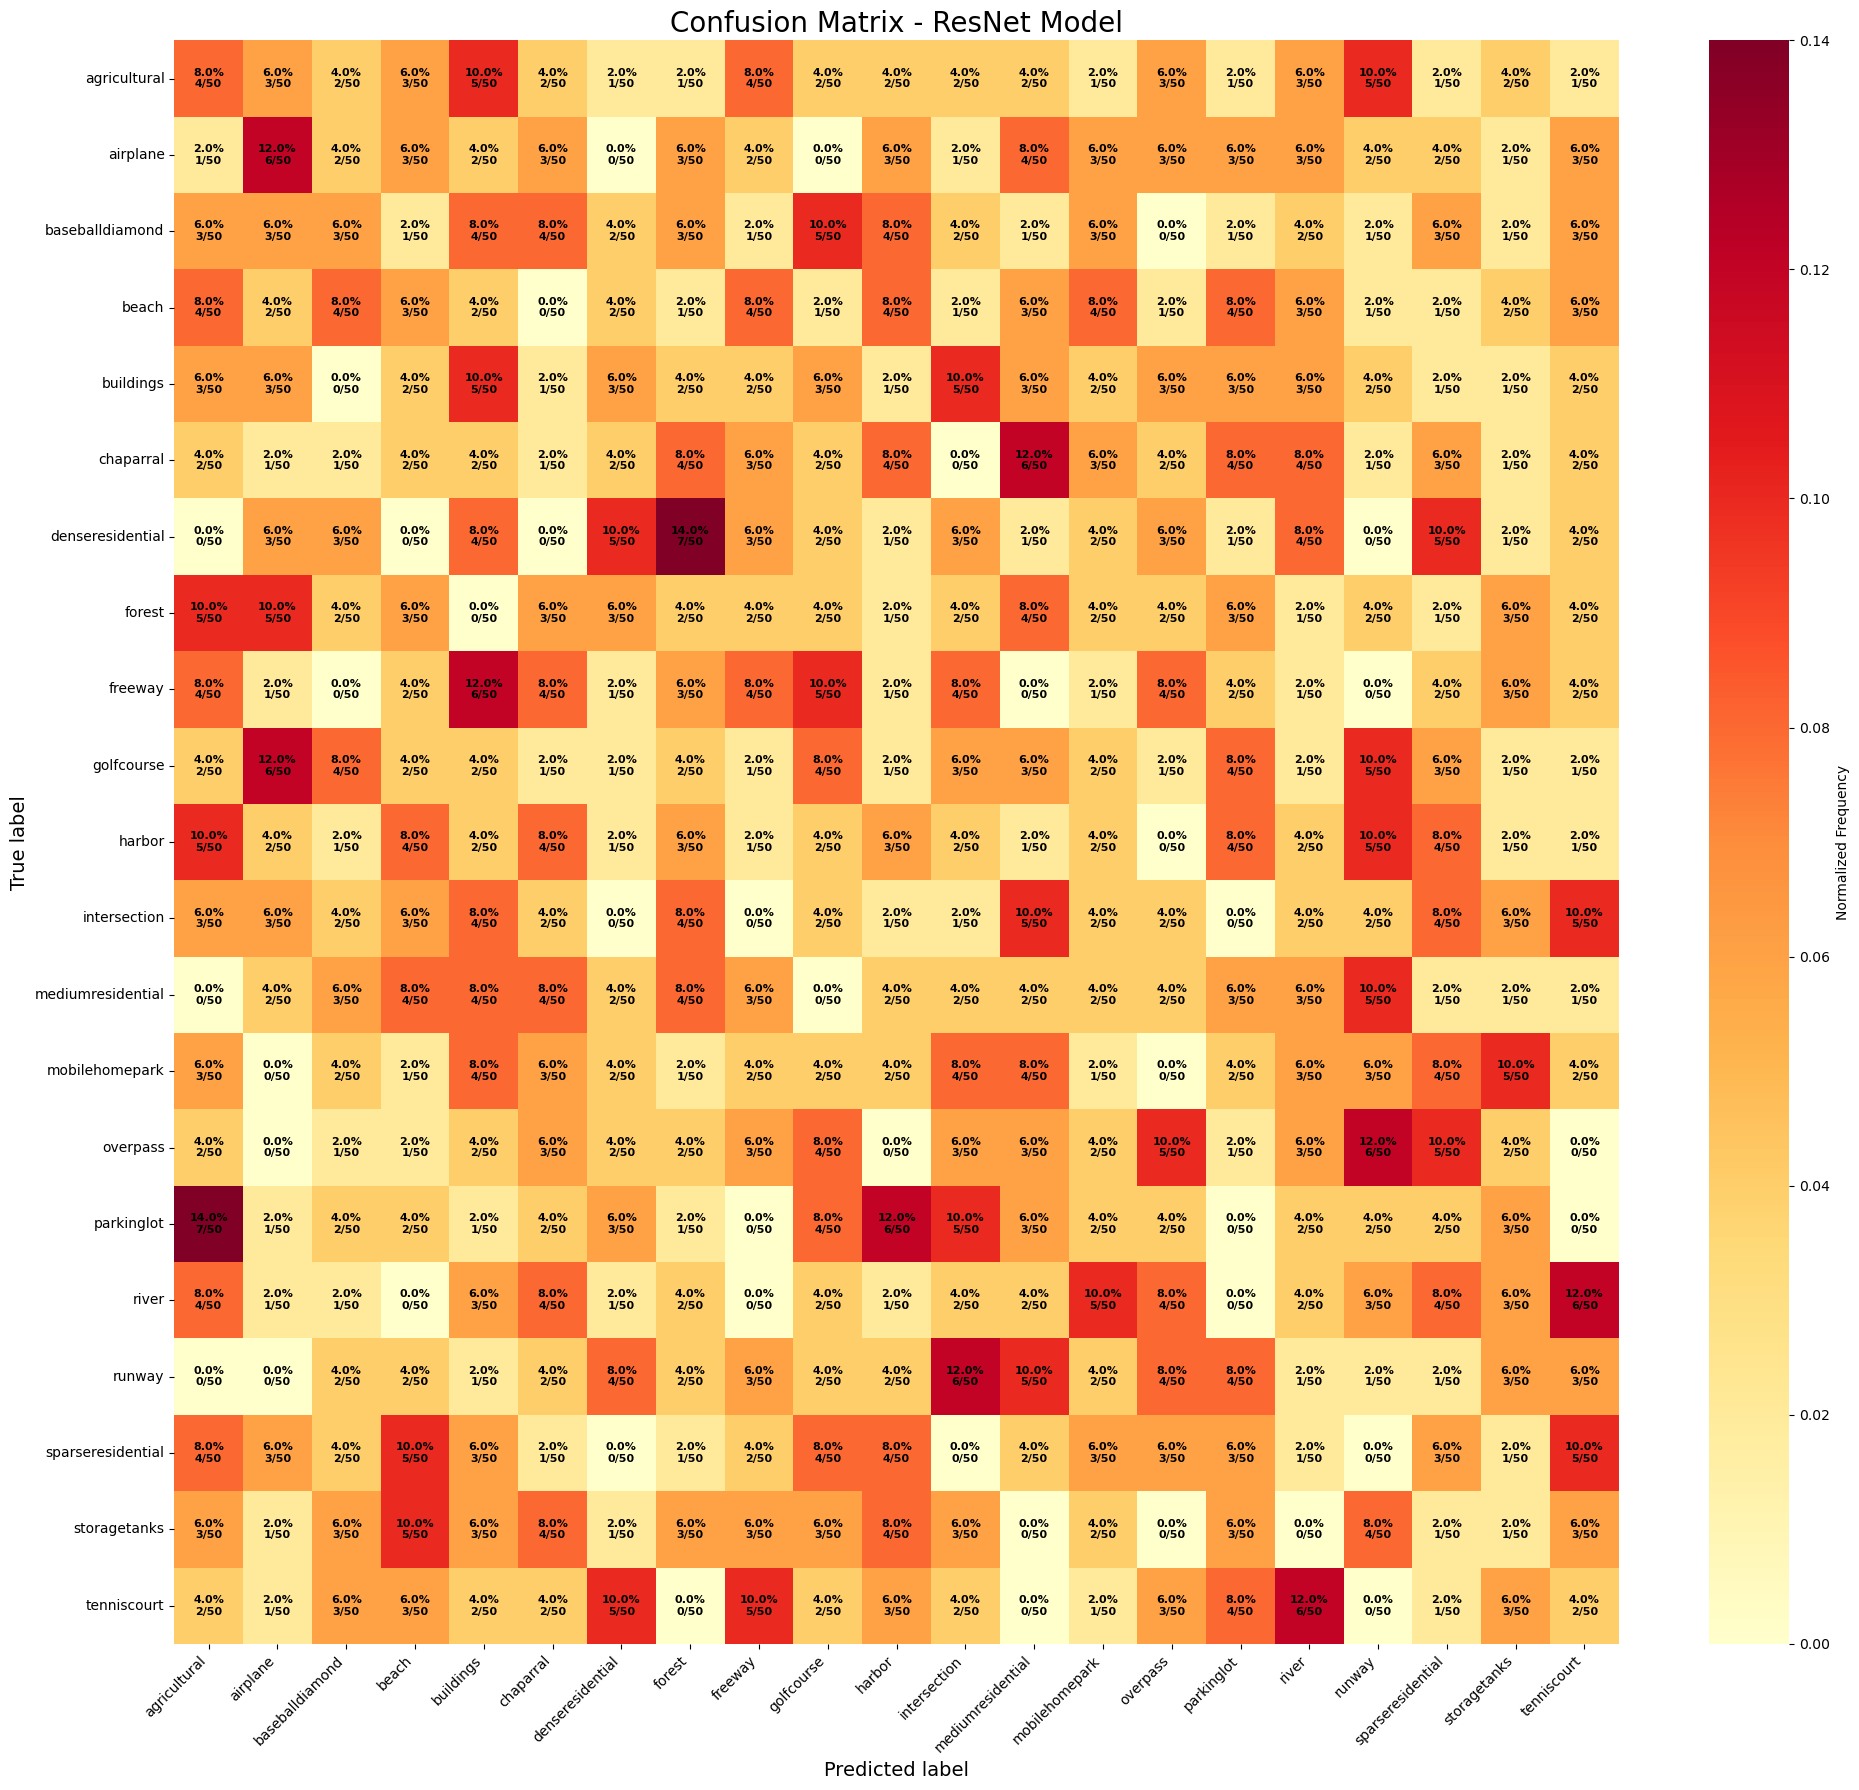

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

# Load the best model (assuming you've saved it during training)
model = load_model('models/best_ResNet_model.keras')

# Get predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a figure and axis
plt.figure(figsize=(20, 18))

# Plot the heatmap
sns.heatmap(cm_normalized, annot=False, cmap='YlOrRd', 
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'label': 'Normalized Frequency'})

# Customize the plot
plt.title('Confusion Matrix - ResNet Model', fontsize=20)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Add text annotations for percentages and absolute values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j+0.5, i+0.5, f"{cm_normalized[i, j]:.1%}\n{cm[i, j]}/{cm[i, :].sum()}", 
                 ha="center", va="center", color="black" if cm_normalized[i, j] < 0.5 else "white", 
                 fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()